In [1]:
# Run this cell and select the kaggle. json file downloaded
# from the kaggle account setting page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"meyadasaisan","key":"42fee32570384ec773e7416e42402d45"}'}

We will begin by connecting to Kaggle via the Kaggle API, which can be downloaded from your Kaggle account settings and uploaded here.

In [2]:
# next, install the kaggle api client.
!pip install -q kaggle

In [3]:
# The kaggle api client expose thrs file to be in /.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# this permission change avoids a warning on kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# creating dir and changing the current working dir
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [5]:
# searching for dataset
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           2299          6  0.1764706        


In [6]:
# downloading dataset and coming out of dir
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

100% 689M/691M [00:22<00:00, 42.0MB/s]
100% 691M/691M [00:22<00:00, 32.0MB/s]
/content


In [7]:
# unzipping downloaded file and removing unsable file
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

In [8]:
# import libraries imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tqdm import tqdm
import keras.utils as image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.regularizers import l2

In [9]:
# read the labels.csv file and checking shape and records
labels_all = pd.read_csv('dog_dataset/labels.csv')
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
# Visualize the number of each breeds
breeds_all = labels_all["breed"]
breed_counts = breeds_all.value_counts()
breed_counts.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [11]:
# selecting first 3 breeds (limitation due to computation power)
class_name = ['scottish_deerhound','maltese_dog','bernese_mountain_dog']
labels = labels_all[(labels_all['breed'].isin(class_name))]
labels = labels.reset_index()
labels.head()


,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


In [12]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# one hot encoding
Y_data = label_binarize(labels['breed'], classes=class_name)


# reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
  img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
  img = image.img_to_array(img)
  x = np.expand_dims(img.copy(), axis=0)
  X_data[i] = x / 255.0


# printing train image and one hot encode shape & size
print('\nTrain Images shape:', X_data.shape,'size: {:,}'.format(X_data.size))
print('\nOne-hot encoded output shape: ', Y_data, 'size: {:,}'.format(Y_data.size))

100%|██████████| 357/357 [00:01<00:00, 242.58it/s]


Train Images shape: (357, 224, 224, 3) size: 53,738,496

One-hot encoded output shape:  [[1 0 0]
 [0 1 0]
 [1 0 0]
 ...
 [0 0 1]
 [0 1 0]
 [0 1 0]] size: 1,071


In [13]:
# Build the model
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu',  kernel_regularizer=l2(0.0002)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu',  kernel_regularizer=l2(0.0002)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=8, kernel_size=(5,5), activation='relu',  kernel_regularizer=l2(0.0002)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0002)))
model.add(Dense(64, activation='relu',  kernel_regularizer=l2(0.0002)))
model.add(Dense(len(class_name), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 16)        12816     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 16)       0

In [14]:
# spliting the data set into training and testing data sets
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X_data, Y_data, test_size=0.1)
# spliting training data set into training and validation data s
X_train, X_val, y_train, Y_val = train_test_split(X_train_and_val, y_train_and_val, test_size=0.2)

In [15]:
# training the model
epochs=200
batch_size = 128

history = model.fit(
    X_train,
    y_train, 
    batch_size=batch_size, 
    epochs=epochs,
    validation_data=(X_val, Y_val))

Epoch 1/200
2/2 [==============================] - 14s 2s/step - loss: 1.1761 - accuracy: 0.3320 - val_loss: 1.1738 - val_accuracy: 0.3692
Epoch 2/200
2/2 [==============================] - 1s 394ms/step - loss: 1.1712 - accuracy: 0.3945 - val_loss: 1.1698 - val_accuracy: 0.5077
Epoch 3/200
2/2 [==============================] - 1s 384ms/step - loss: 1.1679 - accuracy: 0.4805 - val_loss: 1.1655 - val_accuracy: 0.5231
Epoch 4/200
2/2 [==============================] - 1s 382ms/step - loss: 1.1645 - accuracy: 0.4727 - val_loss: 1.1602 - val_accuracy: 0.5385
Epoch 5/200
2/2 [==============================] - 1s 383ms/step - loss: 1.1597 - accuracy: 0.4805 - val_loss: 1.1540 - val_accuracy: 0.5231
Epoch 6/200
2/2 [==============================] - 1s 383ms/step - loss: 1.1548 - accuracy: 0.4961 - val_loss: 1.1483 - val_accuracy: 0.5385
Epoch 7/200
2/2 [==============================] - 1s 387ms/step - loss: 1.1485 - accuracy: 0.5273 - val_loss: 1.1414 - val_accuracy: 0.5385
Epoch 8/200
2/2

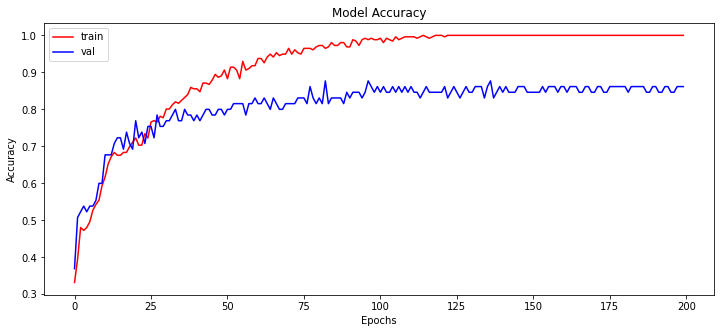

In [16]:
# Plot the training history
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [17]:
# Here we analyse how the model is learning with each epoch in terms of accuracy.
y_pred = model.predict(X_test)
score = model.evaluate(X_test, y_test)
print('Accuracy over the best set: \n', round((score[1]*100), 2), '%')

2/2 [==============================] - 0s 12ms/step - loss: 1.0828 - accuracy: 0.8333
Accuracy over the best set: 
 83.33 %


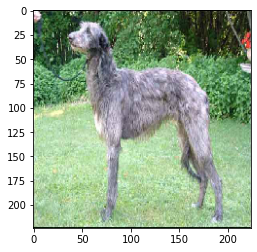

Originally:  scottish_deerhound
Predicted:  scottish_deerhound


In [18]:
# Ploting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

# fiinding max value from predictions list and comparing origin vs predicted
print('Originally: ', labels['breed'][np.argmax(y_test[1])])
print('Predicted: ', labels['breed'][np.argmax(y_pred[1])])